# Reproducibility analysis

Here we are going to analyze the exported data of the skiboot testing machine (force, angular displacement) in terms of reproducibility. The machine data export in .tdms format is converted by "Tdms File Importer" created by Raph to .csv files which contain for every experiment the data of all below listed sessions.   

Lab experiments at Montebellunay, 08.01.2021: Cyclic loading of TLT Speedfit DX and SX with maximal angular displacement as input, starting at an absolut neutral angle of 15°

Frequency: f=0.7 Hz, ambient = 20°C, cold = -20°C

Session 1: max. 20,5°, Session 2: max. 22,5°, Session 3: max. 25,5°, Session 4: max. 30,5°


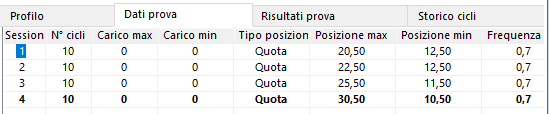

For each boot (DX and SX) two experiments (ambient and cold) were done containing 4 sessions a 10 cycles each. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Insert the file name exported from "Tdms File Importer" in mtb_filename.

In [2]:
# Load data from csv file
mtb_filename = 'Montebelluna_8Jan21_time_series.csv'

df_mtb = pd.read_csv(mtb_filename, index_col = 0)

# Converting time column into correct time format
df_mtb["time"] = pd.to_datetime(df_mtb["time"])
df_mtb.sort_values("time", inplace = True)
df_mtb.reset_index(drop = True, inplace = True)

# Select experiment names and sessions from df
exp = df_mtb["experiment"].unique()
size_exp = len(exp)
session = df_mtb["session #"].unique()
size_session = len(session)
cycle = df_mtb["cycle #"].unique()
size_cycle = len(cycle)

print("Start time: " + str(df_mtb["time"].min()))
print(df_mtb.info())
print(size_session)

Start time: 2021-01-08 10:10:55.052250
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400070 entries, 0 to 400069
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        400070 non-null  datetime64[ns]
 1   experiment  400070 non-null  object        
 2   session #   400070 non-null  int64         
 3   cycle #     400070 non-null  int64         
 4   position    400070 non-null  float64       
 5   force       400070 non-null  float64       
 6   temp        400070 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 21.4+ MB
None
5


# Experiment comparison per session

In the following section we are going to extract the cycle 1 for each experiment session and compare them with in a common plot divided per session. This should help to get an idea of the differences between left and right boot and the impact of temperature. To note: in literature the values used in this kind of plot are often mean values of multiple cycles.

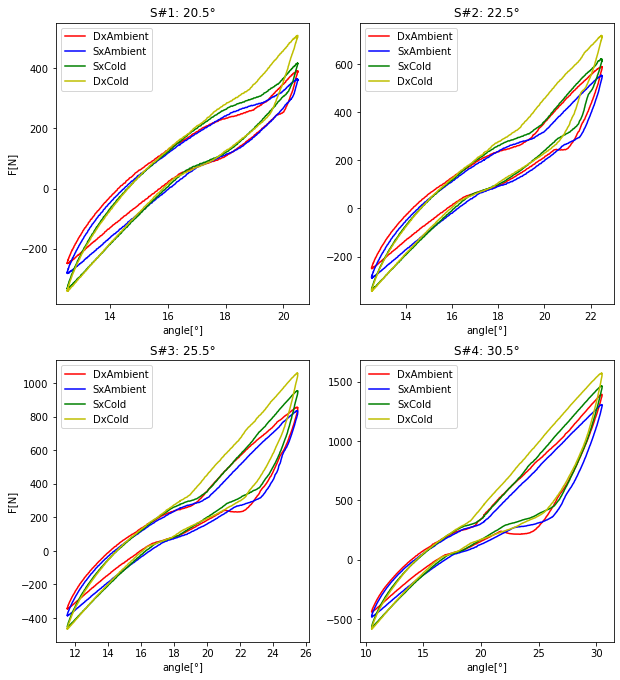

In [3]:
# Get force and position values for cycle 1 for each exp and session
def getSession(experiment,s_nr):
    df_exp = df_mtb[df_mtb["experiment"] == experiment]
    df_exp_s = df_exp[df_exp["session #"] == s_nr]
    df_exp_c = df_exp_s[df_exp_s["cycle #"]== 1]
    df_exp_f = df_exp_c["force"]
    df_exp_t = df_exp_c["time"]
    df_exp_a = df_exp_c["position"]
    return df_exp_t, df_exp_f, df_exp_a

# Force - angle plot
line_col = ['r','b','g','y','c','m']
fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))
for i in range(size_exp):    
    ax1[0,0].plot(getSession(exp[i],1)[2],getSession(exp[i],1)[1],line_col[i])
    ax1[0,1].plot(getSession(exp[i],2)[2],getSession(exp[i],2)[1],line_col[i])
    ax1[1,0].plot(getSession(exp[i],3)[2],getSession(exp[i],3)[1],line_col[i])
    ax1[1,1].plot(getSession(exp[i],4)[2],getSession(exp[i],4)[1],line_col[i])
    ax1[0,0].set_ylabel('F[N]')
    ax1[1,0].set_ylabel('F[N]')
    ax1[0,0].set_title('S#1: 20.5°')
    ax1[0,1].set_title('S#2: 22.5°')
    ax1[1,0].set_title('S#3: 25.5°')
    ax1[1,1].set_title('S#4: 30.5°')

for ax1 in fig1.axes:
    ax1.legend(exp)
    ax1.set_xlabel('angle[°]')
fig1.subplots_adjust(top=1.2)
plt.show()

Within each session the maximum angle in forward lean is increased, unfortunately we didn't standardized the minimum angle (backward direction). For session 1 and 2 it is equal, for 3 and 4 it is different. It is clearly visible that for the same session the values for left and right boot differ. The reasons could be the following: each boot has its own flex pattern because of differnces in the fabrication, influence of liner (displacement between liner and shell), movement between plastic parts. This is a important fact that should always be considered in the Bootsensing project: every boot needs to be calibrated.
It is also worth to mention the influence of the temperature: it seems that the booting is getting stiffer the colder it is. In addition it is also interesting that the offset between left and right boot is getting bigger by lowering the temperature. One reason of this phenomena could be that one boot was longer in the freezer than the other, which could had an influence on the real temperature of the boot. Unfortunately we are not able to measure the temperature of the plastic material but the only the ambiental one. In future experiments we need to handle this better, maybe working with the climatic chamber of the skiboot testing machine altough is very time consuming.

# Standard deviation analysis
For each experiment the standard deviation of the ratio "force/angle" is calculated for every single session 1-4. The result is shown in the plot below. The variable "angle" corresponds to the absolute machine position and "force" to the force neede to cause the angular displacement defined in "angle". 
Attention: For "DXAmbient" only cycle 1 and 10 have been registred, for the other 3 experiments 10 cycles each. 

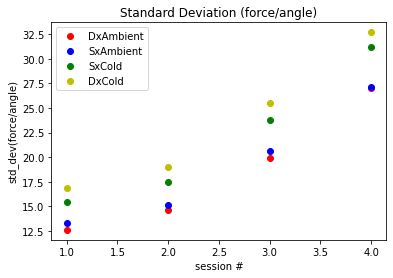

In [4]:
# Standard deviation (force/pos) for each experiment session

session = list(range(1,size_session))

def getStd(experiment,s_nr):
    df_exp = df_mtb[df_mtb["experiment"] == experiment]
    df_exp_s = df_exp[df_exp["session #"] == s_nr]
    std_exp_f_angle = np.std(df_exp_s['force']/df_exp_s['position'])
    return std_exp_f_angle

# Plot of std(F/pos)
colors = ['ro','bo','go','yo','co','mo'] # Define colors

for s in session:
    for i in range(0,len(exp)):
        plt.plot(s,getStd(exp[i],s),colors[i]) # plot std for each session
plt.legend(exp) # create legend
plt.title('Standard Deviation (force/angle)')
plt.xlabel('session #')
plt.ylabel('std_dev(force/angle)')
plt.show()

The trend between the experiments is similar, the standard deviation of the force/angle ratio in DXambient and SXambient for each session seems quite similar, where there is a significant offset between the "ambient" and "cold" experiments.
It has to be mentioned, that every boot seems to deliver different result on the skiboot testing machine, but also at the current project stage we are not sure about the influences on the test method itself, e.g. discrapancy between left and right prothesis, buckle closure, but also the movement between the liner and the outer shell could be a influencing coefficient. The difference between DxCold and SxCold is mainly due to the method of setting the temperature, probably the DX boot was colder than the left one.

# MinMax analysis

The protocol for the different experiments is always the same: for each session 1-4 the boot is loaded in forward lean until a maximum angle (named 'position' in the dataframe) for every single cycle 1-10 and the correspondent force is measured. Also in backward a minimum angle is presetted and the corresponding force evaluated. In this section we will take a look at the forces for the maximum and minimum angle for the single cycles within a session of an experiment.
In addition also the difference in amplitude between peaks (max) and valleys (min) for each cycle is calculated.

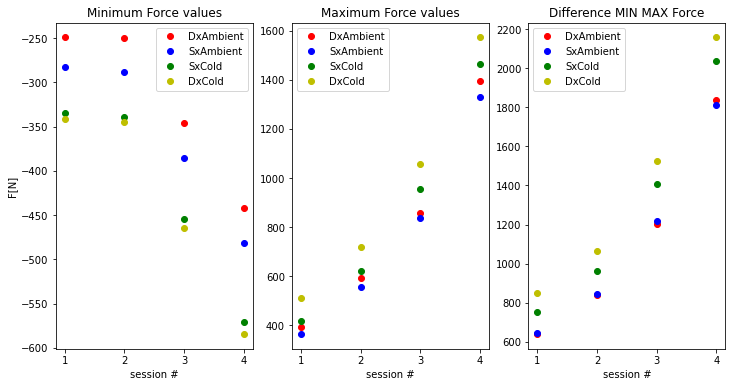

In [5]:
def getPeaksForce(experiment,s_nr):
    df_exp = df_mtb[df_mtb["experiment"] == experiment]
    df_exp_s = df_exp[df_exp["session #"] == s_nr]
    max_force = max(df_exp_s['force'])
    min_force = min(df_exp_s['force'])
    diff_force = max_force - min_force
    return [min_force, max_force, diff_force] 

fig2, ax2 = plt.subplots(1, 3, figsize=(12,6))
for s in range(1,size_session):
    for i in range(0,4):
        ax2[0].plot(s,getPeaksForce(exp[i],s)[0],colors[i])
        ax2[1].plot(s,getPeaksForce(exp[i],s)[1],colors[i])
        ax2[2].plot(s,getPeaksForce(exp[i],s)[2],colors[i])
        ax2[0].set_title('Minimum Force values')
        ax2[1].set_title('Maximum Force values')
        ax2[2].set_title('Difference MIN MAX Force')
        ax2[0].set_ylabel('F[N]')
    
for ax2 in fig2.axes:
    ax2.legend(exp)
    ax2.set_xlabel('session #')
    
plt.show()

It is interesting to note that the maximum values for the experiment DxAmbient and SxAmbient seem to be quite equal, whereas there a bigger differences for the minimum values. Looking at the experiments "DxCold" and "SxCold" it seems to be the opposite. For the experiments with ambiental temperature the differences between the peak values seem to be similar, wheres the ones with cold temperature are quite different, mainly due to the method used for setting the temperature.
The difference between ambiental and cold values are quite different for the maximum plot as the forces in forward lean vary more than in backward direction.

# MinMax Plot

In the following plot the minimum and maximum values for all cycles divided by experiment and session are shown.

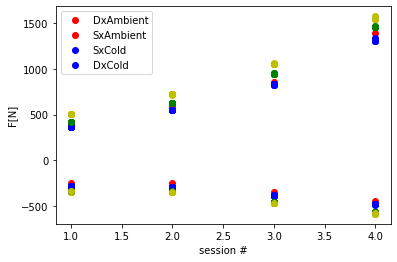

In [6]:
def getPeaksCycle(experiment,s_nr,c_nr):
    df_exp = df_mtb[df_mtb["experiment"] == experiment]
    df_exp_s = df_exp[df_exp["session #"] == s_nr]
    df_exp_s_c = df_exp_s[df_exp_s["cycle #"] == c_nr]
    max_force = max(df_exp_s_c['force'])
    min_force = min(df_exp_s_c['force'])
    return [min_force, max_force] 

for s in range(1,size_session):
    plt.plot(s,getPeaksCycle("DxAmbient",s,1)[1],colors[0],s,getPeaksCycle("DxAmbient",s,1)[0],colors[0],label="DxAmbient")
    
    for i in range(1,size_cycle):
        plt.plot(s,getPeaksCycle("SxAmbient",s,i)[1],colors[1],s,getPeaksCycle("SxAmbient",s,i)[0],colors[1],label="SxAmbient")
        plt.plot(s,getPeaksCycle("SxCold",s,i)[1],colors[2],s,getPeaksCycle("SxCold",s,i)[0],colors[2],label="SxCold")
        plt.plot(s,getPeaksCycle("DxCold",s,i)[1],colors[3],s,getPeaksCycle("DxCold",s,i)[0],colors[3],label="DxCold")
plt.ylabel('F[N]')
plt.xlabel('session #')
plt.legend(["DxAmbient","SxAmbient","SxCold","DxCold"])
plt.show()


# Standard Deviation per experiment and session

In the following the maximum values of each cycle for all sessions were calculated. As for DxAmbient we exported only one cycle per session, this experiment will no be included in this analysis because of the lack of comparable values.

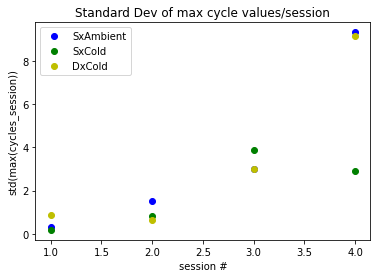

In [27]:
# Initalization of DataFrames for maximum per cycle calculation
max_SxAmbient = pd.DataFrame()
max_DxCold = pd.DataFrame()
max_SxCold = pd.DataFrame()

for s in range(1,size_session):
    for i in range(1,size_cycle):
        
        max_SxAmbient.loc[i,s] = getPeaksCycle("SxAmbient",s,i)[1]
        max_SxCold.loc[i,s] = getPeaksCycle("SxCold",s,i)[1]
        max_DxCold.loc[i,s] = getPeaksCycle("DxCold",s,i)[1]
        
stdmax_SxAmbient = np.std(std_max_SxAmbient.loc[:])
stdmax_SxCold = np.std(std_max_SxCold.loc[:])
stdmax_DxCold = np.std(std_max_DxCold.loc[:])

plt.plot(stdmax_SxAmbient,colors[1],stdmax_SxCold,colors[2],stdmax_DxCold,colors[3])
plt.ylabel('std(max(cycles_session))')
plt.xlabel('session #')
plt.legend(['SxAmbient','SxCold','DxCold'])
plt.title('Standard Dev of max cycle values/session')
plt.show()

# Peak variation

Calculation of the difference between highest and lowest force value within one session for each experiment to check the values range. Also for this analysis the DxAmbient experiment is not considered.

In [43]:
range_values = pd.DataFrame()
for s in range(4):
    range_values.loc[0,s] = max_SxAmbient.iloc[:,s].max() - abs(max_SxAmbient.iloc[:,s].min())
    range_values.loc[1,s] = max_SxCold.iloc[:,s].max() - abs(max_SxCold.iloc[:,s].min())
    range_values.loc[2,s] = max_DxCold.iloc[:,s].max() - abs(max_DxCold.iloc[:,s].min())
range_values 

,0,1,2,3
0,1.138868,5.429458,9.222541,26.811265
1,0.619940,2.354423,12.264972,9.606845
2,2.450622,2.061425,9.629719,29.485751


It seems that with an increasing maximum angular displacement (increasing session number) also the difference of force values is raising, with the only outlier of the SxCold experiment (index 1) for session 3 and 4. 

# Temperature analysis

We are going to compare shortly the difference between the SxAmbient(20°C) and SxCold(-20°C) experiment in terms of force values to get an idea how much influence the temperature has. The experiment protocol is the same for both experiments.

            0
0   52.515243
1   68.259686
2  118.411839
3  134.831893


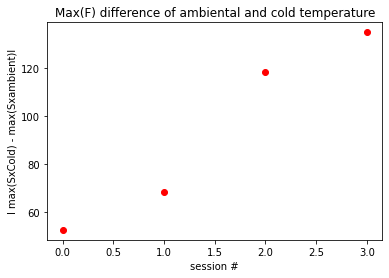

In [55]:
temp_range = pd.DataFrame()
for s in range(4):
    temp_range.loc[s,0] = abs(max_SxAmbient.iloc[:,s].max() - max_SxCold.iloc[:,s].max())
print(temp_range)
plt.plot(temp_range,'ro')
plt.ylabel('I max(SxCold) - max(Sxambient)I')
plt.xlabel('session #')
#plt.legend(['SxAmbient','SxCold','DxCold'])
plt.title('Max(F) difference of ambiental and cold temperature')
plt.show()